# What can we do with multiple readouts from the network?

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm
import torch

In [2]:
from src.model.setup import image_model_setup

W0126 18:55:08.552000 73226 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [3]:
model_name = "facebook/dinov2-base"
dataset_name = "temp_dataset_subsample"

model, image_datasets, _ = image_model_setup(model_name, dataset_name, 1000)


Resolving data files:   0%|          | 0/47 [00:00<?, ?it/s]

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from src.initialization.activity_dataset import generate_activity_dataset
generate_activity_dataset(model, image_datasets, device='mps')

In [4]:
from datasets import load_dataset
activity = load_dataset('temp_activity_dataset')

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

## Agreement / disagreement in different readouts

In [5]:
from src.model.harness import shuffle_randomizer
from src.train.middle_decoders import fit_probes_by_ridge_regression

inds = [2,5,8,11]

probes = fit_probes_by_ridge_regression(model, activity, inds)

hooks = model.add_internal_readouts(inds, readout_functions=probes,
                                    randomizers={layer: shuffle_randomizer for layer in probes.keys()
                                    })

In [6]:
model.to('mps')

In [7]:
full_predictions = {layer: [] for layer in probes.keys()}
full_predictions = full_predictions | {'label': []}

def update_predictions(batch_outs):
    for key in full_predictions.keys():
        full_predictions[key].append(batch_outs[key])

dl = torch.utils.data.DataLoader(image_datasets['test'], batch_size=64)

for batch in dl:
    full_outs = model.model( batch['input'].to('mps') )
    middle_results = model.get_batch_readout()
    middle_results['label'] = batch['label']
    
    update_predictions(middle_results)

In [13]:
for key, value in full_predictions.items():
    full_predictions[key] = torch.concat(value)

What are the individual accuracies?

In [20]:
for layer_name, decoded in full_predictions.items():
    if layer_name != 'label':
        preds = decoded.argmax(1)
        print(layer_name, (preds == full_predictions['label']).float().mean())
        

dinov2.encoder.layer.2 tensor(0.0667)
dinov2.encoder.layer.5 tensor(0.2334)
dinov2.encoder.layer.8 tensor(0.3882)
dinov2.encoder.layer.11 tensor(0.7429)


This is approximately consistent with the results in notebook 0.1: ~28% accuracy in layer 5, ~40% accuracy in layer 8, ~75% in layer 11.

The accuracies here are slightly lower than before, probably due to randomization of earlier layers. Consistent with notebook 1.0, this causes a slight, but not major, loss of accuracy 

This highlights a core tension in what we are trying to achieve: randomization can kill accuracy in the next layer, but also gives us independent readout samples (conditioned on input). That said, the fact that higher layers are also less impacted by randomization of previous layers is reason to be optimistic.

__Several possible directions:__
- more subtle readouts from lower layers (ranks, etc)
- optimized randomizer and readout per layer



### Relationship between readouts

In [108]:
layer8 = full_predictions['dinov2.encoder.layer.8']
layer11 = full_predictions['dinov2.encoder.layer.11']

is_correct = full_predictions['dinov2.encoder.layer.11'].argmax(1) == full_predictions['label']

In [104]:
from scipy.stats import spearmanr

def rank_correlations(layera, layerb):
    correlations = [spearmanr(layera[i, :], layerb[i,:]).statistic
                    for i in tqdm(range(layera.shape[0]))]
    return np.array( correlations)

In [105]:
outs = rank_correlations(layer8, layer11)

100%|█████████████████████████████████████| 50000/50000 [00:23<00:00, 2144.35it/s]


In [114]:
print( outs[is_correct].mean() )
print( outs[~is_correct].mean() )

0.09092409112597193
0.09853116066308541


Rank correlation is _higher_ for incorrect results?

In [116]:
outs = rank_correlations(full_predictions['dinov2.encoder.layer.5'],
                         full_predictions['dinov2.encoder.layer.11'])
print( outs[is_correct].mean() )
print( outs[~is_correct].mean() )

100%|█████████████████████████████████████| 50000/50000 [00:22<00:00, 2228.00it/s]

0.07010753701578362
0.07582175272239106


In [117]:
outs = rank_correlations(full_predictions['dinov2.encoder.layer.2'],
                         full_predictions['dinov2.encoder.layer.11'])
print( outs[is_correct].mean() )
print( outs[~is_correct].mean() )

100%|█████████████████████████████████████| 50000/50000 [00:22<00:00, 2244.06it/s]

0.0402108722553384
0.044467556553943154


Yes, this appear to hold. Rank correlation is _higher_ for incorrect outputs.

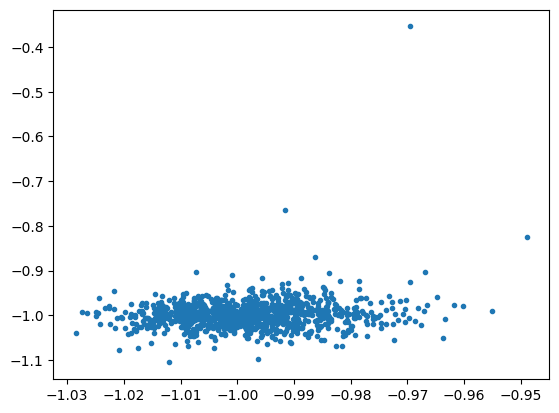

In [128]:
plt.plot( layer8[is_correct][0], layer11[is_correct][0], '.')

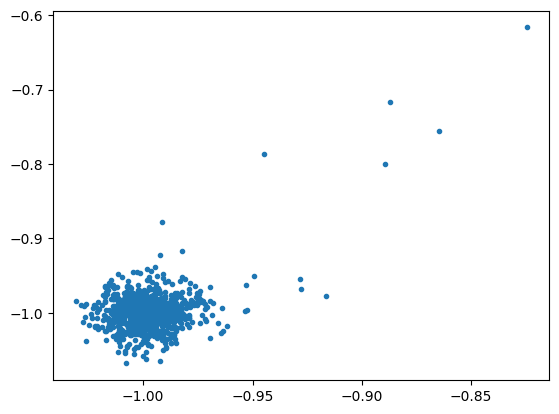

In [131]:
plt.plot( layer8[~is_correct][0], layer11[~is_correct][0], '.')

These plots pretty much capture it: the correlation looks great for this incorrect answer, but not for the correct one.

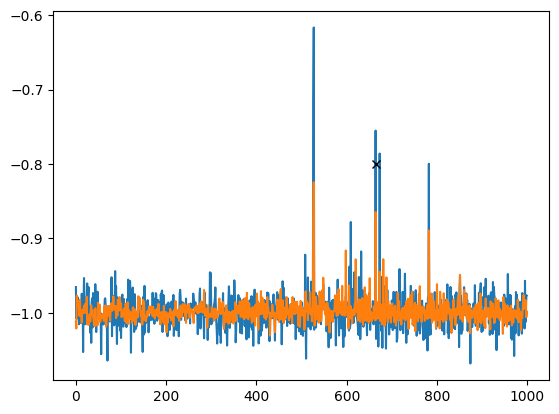

In [150]:
plt.plot(range(0, 1000), layer11[~is_correct][0])
plt.plot(range(0, 1000), layer8[~is_correct][0])
plt.plot(664, -0.8, 'xk')

(The gt is actually the second largest, but even combining would still favor the wrong answer.

In [151]:
layer8_correct = (full_predictions['dinov2.encoder.layer.8'].argmax(1) == full_predictions['label'])

In [152]:
layer8_correct[is_correct].float().mean()

tensor(0.4828)

In [153]:
layer8_correct[~is_correct].float().mean()

tensor(0.1148)

In [154]:
is_correct[layer8_correct].float().mean()

tensor(0.9240)

In [155]:
is_correct[~layer8_correct].float().mean()

tensor(0.6281)

layer 11 correct makes layer 8 correct more likely and vice-versa => there is a connection between the accuracies of these two outputs.

In [156]:
agreement = (full_predictions['dinov2.encoder.layer.8'].argmax(1) == full_predictions['dinov2.encoder.layer.11'].argmax(1))

In [160]:
agreement[is_correct].float().mean()

tensor(0.4828)

In [161]:
agreement[~is_correct].float().mean()

tensor(0.2294)

At the level of pure accuracy, agreement is _more likely_ on correct outputs than incorrect outputs.

#### Overall observations:
1. layer-wise decoders tend to be right / wrong together.
2. layer-wise decoders tend to agree more (in argmax) on correct outputs
3. layer-wise decoders are _less_ rank correlated on correct outputs than incorrect outputs.

This is not what the two examples above show, but a possible explanation for this is that 'body' of the correlation is not as relevant to the actual decoding as the small number of outlers.

The entropy analysis below gives a strong hint: ridge regression probing (which I used to train the probes) gives -1 / 1 outputs, which does not focus on anything 'calibration' related.

#### Questions:
Bayesian decoder accumulation?

How 'independent' are the read-outs really?


#### Entropy curves

In [164]:
import torch.nn.functional as F
def compute_entropy(logits, dim=-1):
    # Convert logits to probabilities
    probs = F.softmax(logits, dim=dim)
    # Calculate log probabilities for numerical stability
    log_probs = F.log_softmax(logits, dim=dim)
    # Entropy = -sum(p * log(p))
    entropy = - (probs * log_probs).sum(dim=dim)
    return entropy

In [188]:
entropies = torch.stack([
    compute_entropy(full_predictions['dinov2.encoder.layer.2'], dim=1),
    compute_entropy(full_predictions['dinov2.encoder.layer.8'], dim=1),
    compute_entropy(full_predictions['dinov2.encoder.layer.11'], dim=1)])

In [199]:
entropies = entropies.T

In [201]:
entropies[0]

tensor([6.9078, 6.9077, 6.9070])

In [212]:
F.softmax(10*full_predictions['dinov2.encoder.layer.8'], dim=1)[0].sum()

tensor(1.0000)

In [223]:
from torch.distributions import Categorical

Categorical(F.softmax(full_predictions['dinov2.encoder.layer.2'][0])).entropy()

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_70546/4126894565.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Categorical(F.softmax(full_predictions['dinov2.encoder.layer.2'][0])).entropy()


tensor(6.9078)

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_70546/2246397707.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(F.softmax(full_predictions['dinov2.encoder.layer.11'][0]))


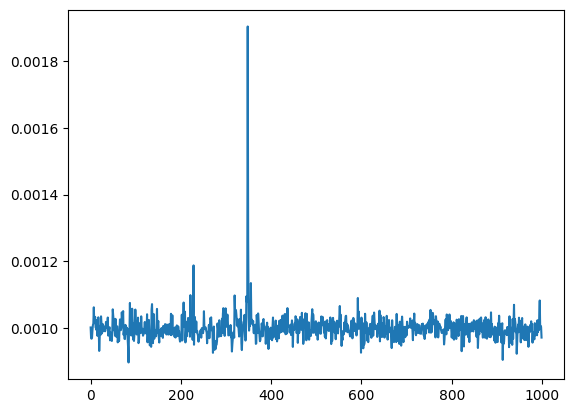

In [227]:
plt.plot(F.softmax(full_predictions['dinov2.encoder.layer.11'][0]))

The entropies are universally quite high. I suspect that this (the large body of ~1/1000 outputs) is the result of the fact that probes are fit by ridge-regression, rather than using a cross-entropy loss, which essentially sets the dynamic range of the output logits.

## Further experiments

In [14]:
model.model.dinov2.encoder.layer[2].forward(torch.randn(10, 257, 768))

tensor([[[-0.7679,  0.2626, -0.4680,  ..., -0.9560, -0.0952, -0.4216],
         [ 0.2032, -1.0278,  0.3818,  ..., -0.9803, -0.0981, -1.2515],
         [ 0.1591, -0.1082,  0.8004,  ..., -0.4324, -0.3005,  1.5090],
         ...,
         [-0.2665, -0.4659, -0.6232,  ..., -0.5800,  0.3238,  0.4664],
         [ 1.3721, -1.1292, -0.6111,  ..., -0.6142,  0.7654, -0.8140],
         [-1.5274,  2.2044,  1.0239,  ...,  0.7451,  0.1541,  0.9168]],

        [[ 0.9890, -0.6718, -1.4813,  ..., -0.1784, -1.9703,  0.3247],
         [-2.2455,  1.2251, -0.1203,  ..., -2.8615, -0.0961,  0.9607],
         [ 1.3267,  0.2508, -0.0471,  ..., -0.6101, -0.3363,  0.0547],
         ...,
         [-0.1656, -0.1275,  0.7317,  ...,  1.6912,  1.1610, -1.1896],
         [-0.7552, -0.0548, -1.0523,  ..., -1.1569, -0.8290, -0.8290],
         [-1.7647,  0.1922,  0.9169,  ...,  1.7520, -0.3949,  0.2276]],

        [[ 1.6374,  0.7135,  0.3548,  ...,  0.5369, -0.5062, -0.4737],
         [-0.9237,  0.9693, -1.7727,  ...,  1

In [12]:
def print_hook(module, inputs, outputs):
    print(inputs[0].shape, outputs.shape)
    
hook = next(model.module_generator())[1].register_forward_hook(print_hook)

In [6]:
batch = next(iter(image_datasets['train']))

In [13]:
model.model.forward(batch['input'].view(1,3,224,224))

torch.Size([1, 257, 768]) torch.Size([1, 257, 768])


ImageClassifierOutput(loss=None, logits=tensor([[ 1.6420e+00,  6.1246e-01, -5.2729e-02, -8.7933e-01, -1.6344e+00,
         -7.5092e-01,  1.7312e+00,  1.2677e+00, -1.2044e+00,  2.3350e+00,
         -3.4588e-01, -1.2852e+00, -1.6022e+00,  2.3488e+00, -4.3683e-02,
         -3.3516e-02, -8.6874e-01, -2.1396e+00, -2.0103e+00,  1.7515e+00,
          2.5660e-01,  1.1318e+00,  1.2185e+00, -1.0625e+00,  2.3178e-03,
          4.5770e-01, -1.2776e+00,  1.9725e-01,  7.4759e-01,  1.0502e+00,
         -5.1593e-01, -3.7401e-01, -1.8756e-01, -1.0237e+00, -7.8758e-02,
          7.8658e-01, -4.0295e-01,  1.4176e+00, -1.1010e+00, -4.4227e-01,
          1.5132e-01, -3.2931e-01,  9.4017e-01,  9.8469e-01,  8.0486e-02,
          4.0522e-02, -1.3227e+00, -1.2264e+00,  1.3800e-01,  6.6736e-01,
          1.4886e+00, -3.8297e-01, -1.0924e+00, -5.4754e-02, -4.9118e-01,
         -1.5453e+00,  2.3615e-01,  1.2178e-01,  6.5875e-01, -5.7179e-01,
          1.5778e-01, -7.7292e-01,  2.2008e-01,  3.0632e-02,  3.1035e-01

In [11]:
hook.remove()